<a href="https://colab.research.google.com/github/sankichi92/satelliteBook/blob/main/notebooks/3-1-data_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-1 衛星データを取得する

[『Pythonで学ぶ衛星データ解析基礎』](https://gihyo.jp/book/2022/978-4-297-13232-3)第3章 衛星データ解析準備より。

In [1]:
!date --rfc-3339=seconds

2023-01-09 09:40:10+00:00


In [2]:
!python --version

Python 3.8.16


In [3]:
!pip install geopandas>=0.12.2 mapclassify pystac-client>=0.5.1 rasterio>=1.3.4

In [4]:
%config InlineBackend.figure_formats = ['retina']

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

関心領域（Area of Interest）の[行政区域コード](https://www.soumu.go.jp/denshijiti/code.html)を決める。

In [6]:
aoi_code = '13113' # 東京都渋谷区

[shikuchoson-boundaries](https://github.com/sankichi92/shikuchoson-boundaries) から関心領域の行政区域界を [GeoPandas](https://geopandas.org/) の GeoDataFrame として読み込む。

In [7]:
import geopandas as gpd

aoi_gdf = gpd.read_file(f'https://shikuchoson-boundaries.sankichi.app/{aoi_code}.geojson')
aoi_gdf

,都道府県,市区町村,行政区域コード,geometry
0,東京都,渋谷区,13113,"POLYGON ((139.68448 35.69050, 139.68442 35.690..."


関心領域が意図したものになっているか、地図上に表示して確認する。

In [8]:
aoi_gdf.explore()

[Earth Search](https://www.element84.com/earth-search/) の STAC API と [PySTAC Client](https://github.com/stac-utils/pystac-client) を使って2022年11月の Sentinel-2 データを検索する。

In [9]:
from pystac_client import Client
client = Client.open('https://earth-search.aws.element84.com/v0')
client

ID: earth-search
Title: Earth Search
Description: A STAC API of AWS Public Datasets powered by stac-server
stac_api_version: 0.9.0
type: Catalog
ID: sentinel-s2-l2a
Title: Sentinel 2 L2A
"Description: Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance)"
Providers: ESA (producer) Sinergise (processor) AWS (host) Element 84 (processor)
stac_extensions: ['https://stac-extensions.github.io/item-assets/v1.0.0/schema.json']
title: Sentinel 2 L2A


In [10]:
[collection.id for collection in client.get_collections()]

['sentinel-s2-l2a',
 'sentinel-s2-l1c',
 'sentinel-s2-l2a-cogs',
 'landsat-8-l1-c1']

In [11]:
res = client.search(
    collections='sentinel-s2-l2a-cogs',
    bbox=aoi_gdf.total_bounds,
    datetime='2022-11',
)
res.matched()

5

検索結果を GeoDataFrame に変換してメタデータを確認する。

In [12]:
res_gdf = gpd.GeoDataFrame.from_features(res.items_as_dicts())
res_gdf

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,sentinel:processing_baseline,sentinel:boa_offset_applied,created,updated
0,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2022-11-28T01:37:22Z,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20221128T013011_N0400_R074_T54SUE_2...,100,95.53,True,04.00,True,2022-11-28T05:57:12.133Z,2022-11-28T05:57:12.133Z
1,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2022-11-23T01:37:21Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20221123T012959_N0400_R074_T54SUE_2...,100,100.00,True,04.00,True,2022-11-23T05:31:43.048Z,2022-11-23T05:31:43.048Z
2,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2022-11-18T01:37:23Z,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_2...,100,3.30,True,04.00,True,2022-11-18T06:17:57.525Z,2022-11-18T06:17:57.525Z
3,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2022-11-13T01:37:21Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20221113T012909_N0400_R074_T54SUE_2...,100,99.66,True,04.00,True,2022-11-14T02:39:58.207Z,2022-11-14T02:39:58.207Z
4,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2022-11-03T01:37:20Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20221103T012819_N0400_R074_T54SUE_2...,100,0.13,True,04.00,True,2022-11-03T06:09:22.190Z,2022-11-03T06:09:22.190Z


もっとも雲量が少ないアイテムのサムネイルを確認する。

In [13]:
item = min(res.items(), key=lambda item: item.properties["eo:cloud_cover"])
item

ID: S2B_54SUE_20221103_0_L2A
"Bounding Box: [138.77761489199077, 35.135011161377925, 140.0097096778842, 36.14069288925992]"
Datetime: 2022-11-03 01:37:20+00:00
datetime: 2022-11-03T01:37:20Z
platform: sentinel-2b
constellation: sentinel-2
instruments: ['msi']
gsd: 10
view:off_nadir: 0
proj:epsg: 32654
sentinel:utm_zone: 54


In [14]:
from IPython.display import Image
Image(url=item.assets['thumbnail'].href)

[Rasterio](https://rasterio.readthedocs.io/) でバンドデータから関心領域のトゥルーカラー画像を表示する。

In [15]:
import rasterio as rio

bands = []
for asset_key in ['B04', 'B03', 'B02']:
  with rio.open(item.assets[asset_key].href) as reader:
    band = reader.read(1)
    bands.append(band)

rgb_memfile = rio.io.MemoryFile()
with rgb_memfile.open(**{**reader.meta, 'count': len(bands)}) as rgb:
  for i, band in enumerate(bands, 1):
    rgb.write(band, i)

In [16]:
import rasterio.mask

with rgb_memfile.open() as rgb:
  masked_image, transform = rio.mask.mask(rgb, aoi_gdf.to_crs(rgb.crs).geometry, crop=True)
  masked_meta = {
      **rgb.meta,
      'height': masked_image.shape[1],
      'width': masked_image.shape[2],
      'transform': transform,
  }

masked_memfile = rio.io.MemoryFile()
with masked_memfile.open(**masked_meta) as masked:
  masked.write(masked_image)

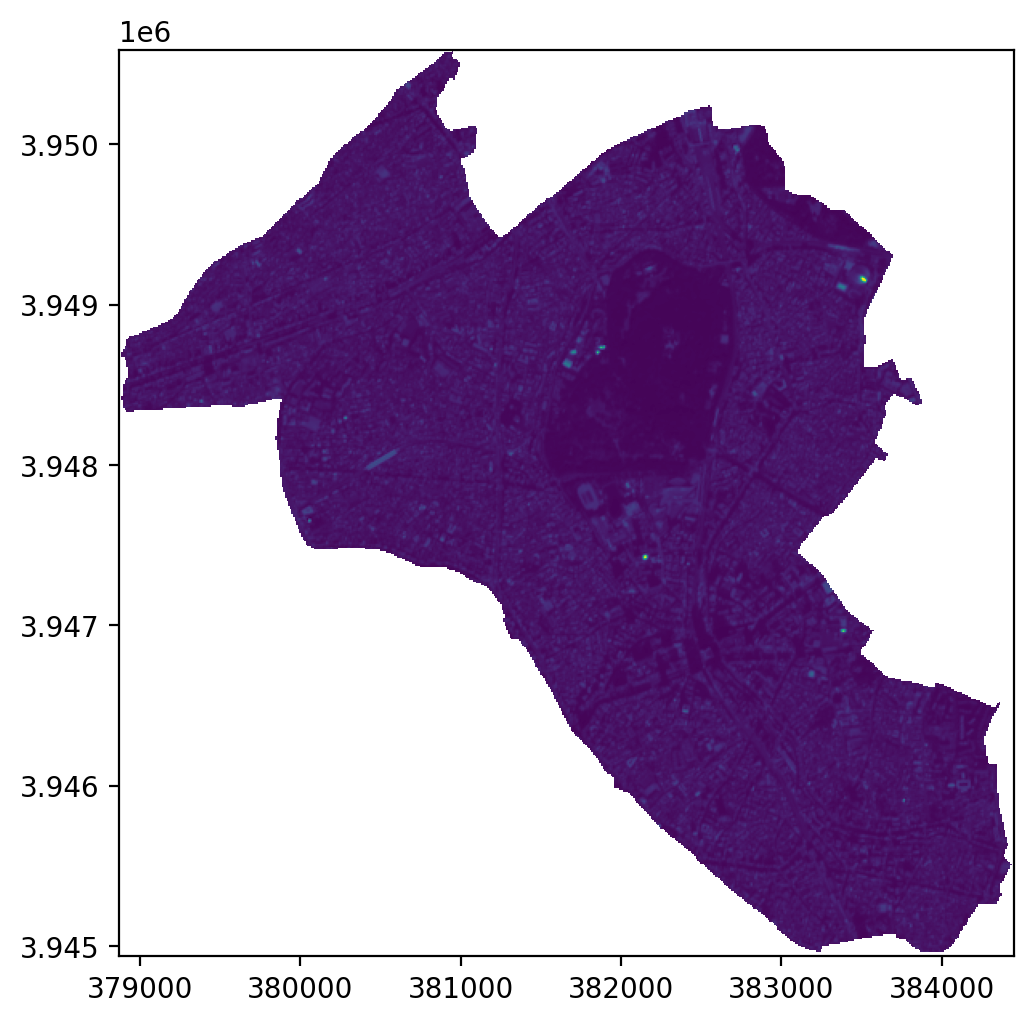

In [17]:
import rasterio.plot

with masked_memfile.open() as masked:
  rio.plot.show(masked)

色が不自然なので、ヒストグラムを確認する。

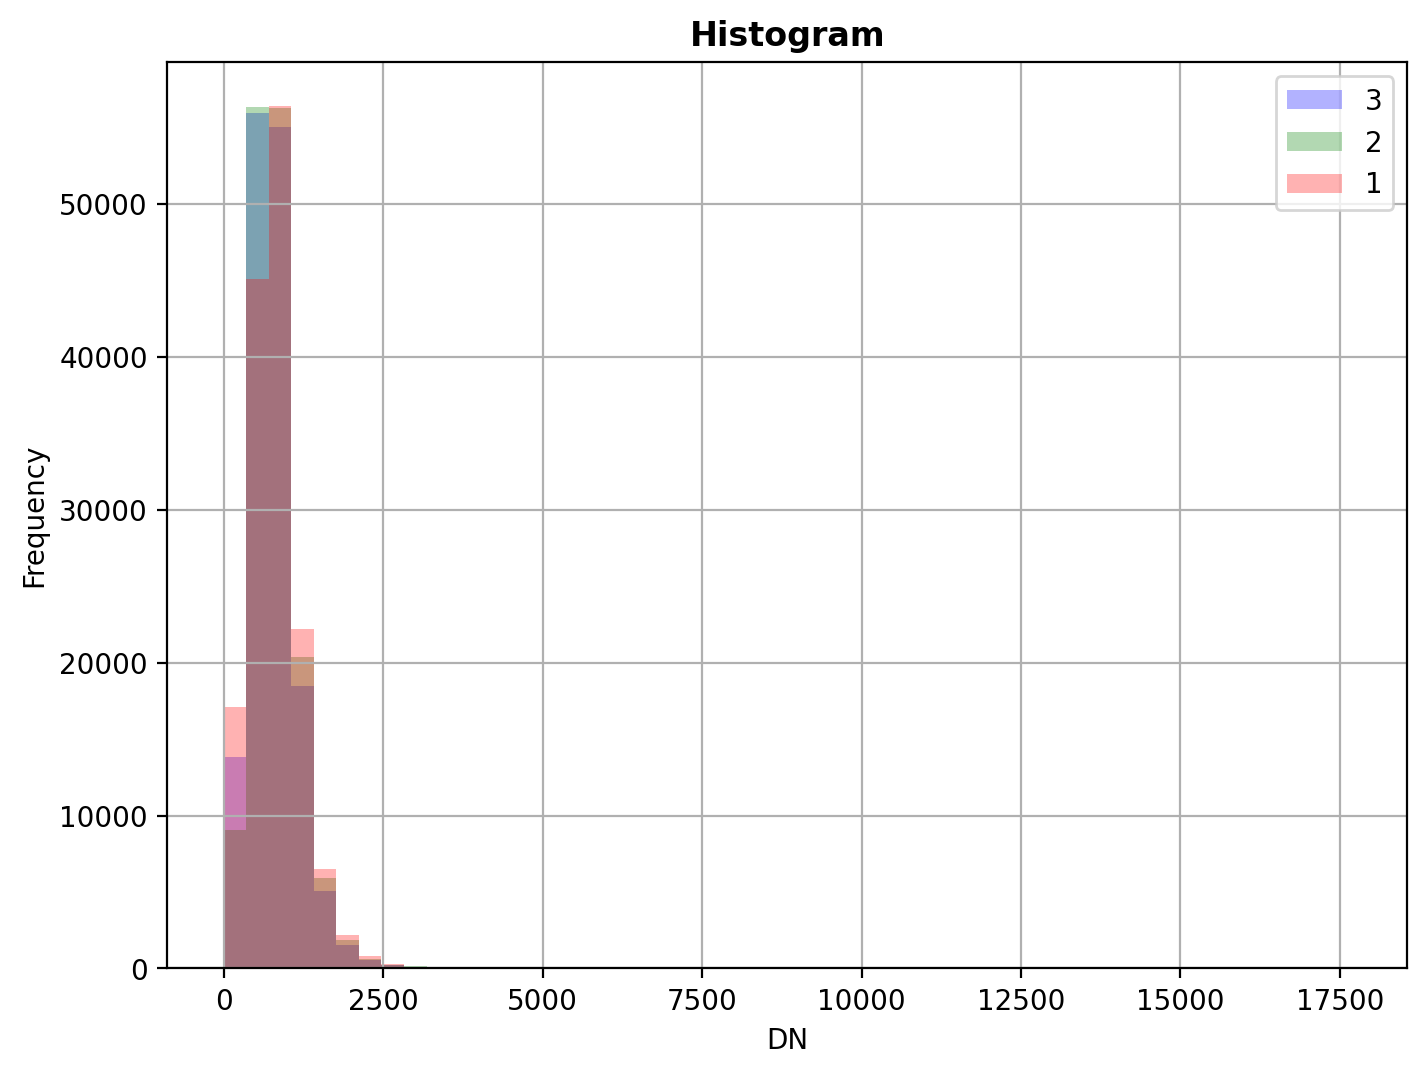

In [18]:
with masked_memfile.open() as masked:
  rio.plot.show_hist(masked, bins=50, histtype='stepfilled', alpha=0.3)

3000以上の値はほとんどないので、0〜3000 のみを使用する。

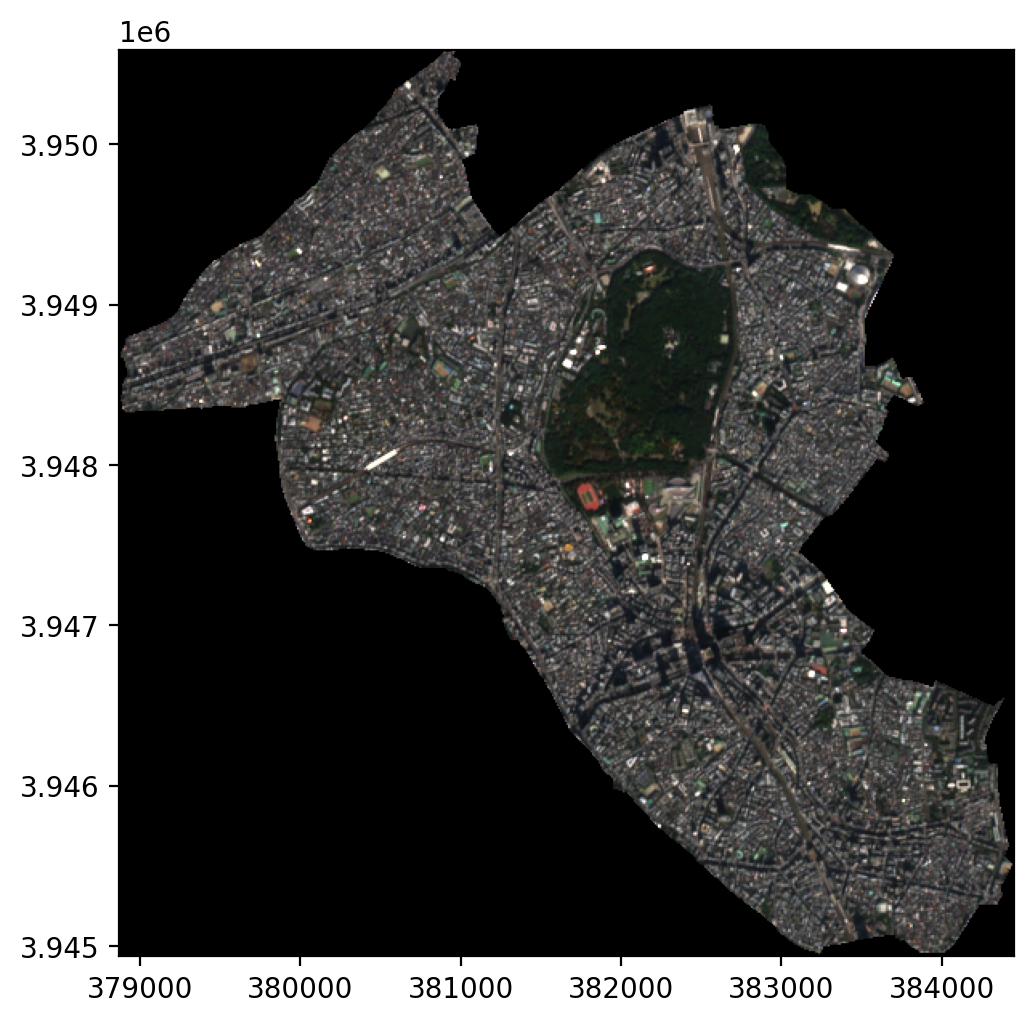

In [19]:
with masked_memfile.open() as masked:
  data = masked.read()
  data = masked.read().clip(0, 3000) * (255 / 3000)
  rio.plot.show(data.astype('uint8'), transform=masked.transform)